# Final Project: Rock-Scissors-Paper (RSP) Agent

Student name: Giorgos Giannios

AEM: 169

The notebook is uploaded in [this](https://github.com/geogiadim/DWS-101-ML-Project) GitHub repository.

### Install/Import Libraries

In [1]:
!pip install tensorflow

In [2]:
import os
from skimage import io, color
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
import keras
from keras import layers, models
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Load dataset and assign labels to each image.

The dataset has been obtained from [Kaggle](https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors) and contains images of hand gestures from the Rock-Paper-Scissors game.

Labels has been assigned to each image as follows:
- 0 -> Rock
- 1 -> Scissor
- 2 -> Paper

In [4]:
rock_dir = '/content/drive/MyDrive/ΠΛΗΡΟΦΟΡΙΚΗ ΑΠΘ/DWS/1st_Semester/DWS101_MachineLearning/FinalProject/rps-cv-images/rock'
scissor_dir = '/content/drive/MyDrive/ΠΛΗΡΟΦΟΡΙΚΗ ΑΠΘ/DWS/1st_Semester/DWS101_MachineLearning/FinalProject/rps-cv-images/scissors'
paper_dir = '/content/drive/MyDrive/ΠΛΗΡΟΦΟΡΙΚΗ ΑΠΘ/DWS/1st_Semester/DWS101_MachineLearning/FinalProject/rps-cv-images/paper'

In [5]:
# loads the dataset given the directory of iamges and the label that will be assigned to them
def load_dataset(directory, class_label):
    images = []
    labels = []

    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = io.imread(img_path)
        img = color.rgb2gray(img)  # Convert to grayscale and normalize the values of the image
        images.append(img)
        labels.append(class_label)

    return np.array(images), np.array(labels)

In [6]:
# Load images and labels for each class
rock_images, rock_labels = load_dataset(rock_dir, 0) # 0 represents Rock label
scissor_images, scissor_labels = load_dataset(scissor_dir, 1) # 1 represents scissor label
paper_images, paper_labels = load_dataset(paper_dir, 2) # 2 represents paper label

### Image Preprocessing

1. Convert to gray scale
2. Normalize pixel values to [0, 1]
3. Reduce dimensionality from 300 x 200 to 30 x 20
<!-- 4. Flatten iamges. Convert images from 2D Array: (30, 20) to 1D Array (600,)  -->

Note: 1 and 2 have been already done in load_dataset function

In [8]:
# reduces the dimensionality of the images with respect to their aspect ratio
def resize_images(images, target_size=(30, 20)):
    resized_images = []
    for img in images:
        # Resize the image while maintaining the aspect ratio
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img)
    return np.array(resized_images)


cv2.INTER_AREA: This method is suitable for reducing the size of the image (downsampling). It uses pixel area relation. When you shrink an image, each pixel in the new image covers a certain area in the original image. cv2.INTER_AREA uses this information to determine the pixel value in the resized image. It's a good choice for preserving details when downsizing.

In [9]:
resized_rock_images = resize_images(rock_images)
resized_scissor_images = resize_images(scissor_images)
resized_paper_images = resize_images(paper_images)

In [ ]:
# flattened_rock_images = resized_rock_images.reshape(resized_rock_images.shape[0], -1)
# flattened_scissor_images = resized_scissor_images.reshape(resized_scissor_images.shape[0], -1)
# flattened_paper_images = resized_paper_images.reshape(resized_paper_images.shape[0], -1)

### Plot sample images

In [62]:
def plot_images(images, labels, class_name, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    plt.suptitle(f'Sample preprocessed Images from {class_name} Class', fontsize=16)


    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')  # Assuming images are in grayscale
        ax.set_xticks([0, 10, 20, 30])  # Set x-axis tick positions
        ax.set_yticks([0, 10, 20])  # Set y-axis tick positions
        # ax.axis('off')

    plt.show()

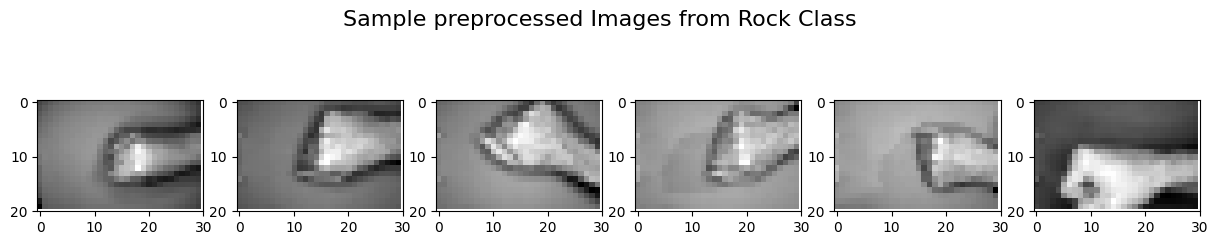

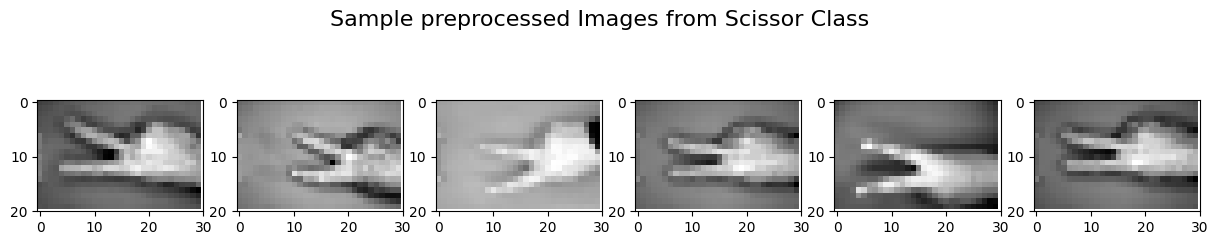

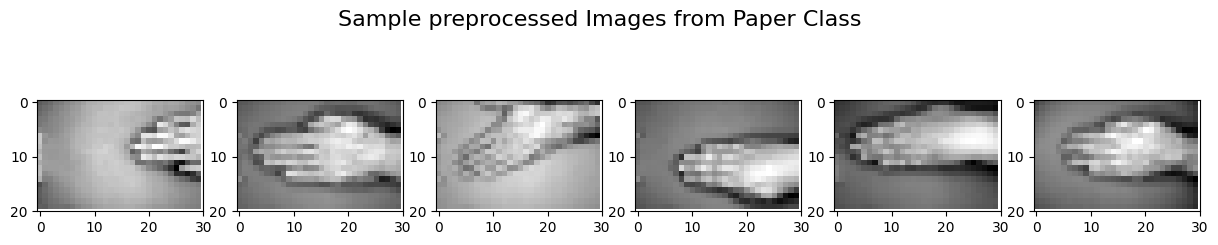

In [63]:
plot_images(resized_rock_images, rock_labels, class_name='Rock')
plot_images(resized_scissor_images, scissor_labels, class_name='Scissor')
plot_images(resized_paper_images, paper_labels, class_name='Paper')

## 2. Split the dataset into train (80%) and test set (20%).



In [10]:
# Concat all pre processed images in one "images" array and all labels in one "labels" array
images = np.concatenate((resized_rock_images, resized_scissor_images, resized_paper_images), axis=0)
labels = np.concatenate((rock_labels, scissor_labels, paper_labels), axis=0)

In [11]:
# Perform stratified train-test split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=0, stratify=labels)

In [12]:
flattened_train_images = train_images.reshape(train_images.shape[0], -1)
flattened_test_images = test_images.reshape(test_images.shape[0], -1)

## 3. Select an Image

(All this code is included in RandomAgent Class)

In [13]:
def select_random_test_image(test_images, test_labels):
    # Check if test_images and test_labels have the same length
    assert len(test_images) == len(test_labels), "Test images and labels must have the same length"

    # Randomly select an index
    random_index = np.random.randint(0, len(test_labels))

    # Retrieve the corresponding test image and label
    random_test_image = test_images[random_index]
    random_test_label = test_labels[random_index]

    return random_test_image, random_test_label

In [14]:
random_test_image, random_test_label = select_random_test_image(test_images, test_labels)

## 4. Selected Image Preprocess

(All this code is included in RandomAgent Class)

In [15]:
def apply_vertical_flip(image, probability=0.5):
    # Check if the flip should be applied based on the probability
    # np.random.rand(): generates random values from a uniform distribution in the half-open interval [0.0, 1.0).
    if np.random.rand() < probability:
        # Apply vertical flip
        flipped_image = np.flipud(image)
        return flipped_image
    else:
        return image  # No flip applied

In [16]:
def apply_horizontal_flip(image, probability=0.5):
    if np.random.rand() < probability:
        # Apply horizontal flip
        flipped_image = np.fliplr(image)
        return flipped_image
    else:
        return image  # No flip applied

In [17]:
def add_noise(image, mean=0, std_dev=0.05):
    # Generate random noise with the specified mean and standard deviation
    noise = np.random.normal(mean, std_dev, size=image.shape)

    # Add the noise to the image
    noisy_image = image + noise

    # Clip values to ensure they remain in the valid range [0, 1]
    noisy_image = np.clip(noisy_image, 0, 1)

    return noisy_image


## RandomAgent Class

This class implements a Random Agent.

The agent is initialized with a set of test images and corresponding labels. By calling the **next_step** function, it randomly selects an image from the test set, applies preprocessing to the selected image, and returns both the preprocessed image and its associated label.

In [18]:
class RandomAgent:
    def __init__(self, test_images, test_labels):
        # Check if test_images and test_labels have the same length
        assert len(test_images) == len(test_labels), "Test images and labels must have the same length"

        self.test_images = test_images
        self.test_labels = test_labels
        self.label_mapping = {0: 'rock', 1: 'scissor', 2: 'paper'}

    def select_random_test_image(self):
        # Randomly select an index
        random_index = np.random.randint(0, len(self.test_labels))

        # Retrieve the corresponding test image and label
        random_test_image = self.test_images[random_index]
        random_test_label = self.test_labels[random_index]

        return random_test_image, random_test_label

    def apply_vertical_flip(self, image, probability=0.5):
        # Check if the flip should be applied based on the probability
        if np.random.rand() < probability:
            # Apply vertical flip
            flipped_image = np.flipud(image)
            return flipped_image
        else:
            return image  # No flip applied

    def apply_horizontal_flip(self, image, probability=0.5):
        if np.random.rand() < probability:
            # Apply horizontal flip
            flipped_image = np.fliplr(image)
            return flipped_image
        else:
            return image  # No flip applied

    def add_noise(self, image, mean=0, std_dev=0.05):
        # Generate random noise with the specified mean and standard deviation
        noise = np.random.normal(mean, std_dev, size=image.shape)

        # Add the noise to the image
        noisy_image = image + noise

        # Clip values to ensure they remain in the valid range [0, 1]
        noisy_image = np.clip(noisy_image, 0, 1)

        return noisy_image

    def image_preprocess(self, image):
        # Apply vertical flip with a probability of 0.5
        image = self.apply_vertical_flip(image, probability=0.5)

        # Apply horizontal flip with a probability of 0.5
        image = self.apply_horizontal_flip(image, probability=0.5)

        # Add noise to the image
        image = self.add_noise(image)

        return image

    def plot_image(self, image, label, step):
        # Plot the image
        plt.imshow(image, cmap='gray')
        plt.title(f"Random Agent's move is {self.label_mapping[label]} for step {step}")
        plt.axis('off')
        plt.show()

    def next_step(self):
        random_image, random_label = self.select_random_test_image()
        random_preprocessed_image = self.image_preprocess(random_image)

        return random_preprocessed_image, random_label

## Models

This section includes all models that was experimented in order to select the optimal one for representing the RSP Agent. Details related with the parameters of each model, the training process and the evaluation are presented. Before models sub-sections, a function that performs cross validation is implemented.

In [19]:
def perform_cross_validation(param_grid, model, train_images, train_labels):
    # Create a StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    # Create GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy')

    # Fit the model to the data
    grid_search.fit(train_images, train_labels)

    return grid_search

- **param_grid** defines the grid of hyperparameters of the model

- **StratifiedKFold** is used for cross-validation to ensure that each fold preserves the percentage of samples for each class.
     
      n_splits: The number of folds or splits in the cross-validation. In this case, n_splits=10 indicates that the dataset will be split into 10 folds for cross-validation.

      shuffle: If True, the data is first shuffled before splitting into folds.

- **GridSearchCV** performs the search over the specified hyperparameter grid.
      estimator: The model to be evaluated. In this case, it's a RandomForestClassifier.

      param_grid: A dictionary specifying the hyperparameter grid to search over.

      cv: The cross-validation strategy or the number of folds. In this case, it's set to a StratifiedKFold with n_splits=10, shuffle=True.

      scoring: The scoring metric used to evaluate the performance of the model. In this case, it's set to 'accuracy'.




### Random Forest

The decision to employ a Random Forest model for RSP agent was motivated by the versatility and simplicity of such models. Random Forests are an ensemble learning method that combines the predictions of multiple decision trees, offering robustness against overfitting and high interpretability. In this scenario, where the task involves classifying images (represented as flattened arrays), Random Forests provide a straightforward approach without the need for complex neural network architectures. The choice of Random Forests allowed for quick experimentation before exploring more complicated models like neural networks.

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200], # Number of trees in the forest.
    'criterion': ["gini", "entropy", "log_loss"], # The function to measure the quality of a split.
    'min_samples_split': [2, 5, 10] # The minimum number of samples required to split an internal node.
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=0)

# Perform cross validation in order to select the best params for the model
grid_search = perform_cross_validation(param_grid, rf_classifier, flattened_train_images, train_labels)

In [ ]:
# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'criterion': 'entropy', 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy: 0.9285714285714285


In [ ]:
# Best Parameters: {'criterion': 'entropy', 'min_samples_split': 5, 'n_estimators': 200}
# Best Accuracy: 0.9285714285714285

# Create a Random Forest classifier with best params
rf_classifier = RandomForestClassifier(n_estimators=200,
                                      criterion="entropy",
                                      min_samples_split=5,
                                      random_state=0)
# Train the Random Forest classifier
rf_classifier.fit(flattened_train_images, train_labels)

RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=200, random_state=0)

In [ ]:
# Make predictions on the test set
predictions = rf_classifier.predict(flattened_test_images)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 90.87%


### MLP (Multi-Layer Perceptron) Model

The decision to use a Multi-Layer Perceptron (MLP) for RSP agent was driven by the simplicity and ease of implementation offered by MLPs, making them a suitable choice for experimentation and initial exploration. MLPs are a foundational type of neural network that can handle various tasks, including classification. In this case, opting for an MLP allowed for a straightforward implementation of a neural network without the complexities associated with convolutional layers and spatial hierarchies. This choice provided a starting point to experiment with neural network architectures before exploring more intricate models like convolutional neural networks (CNNs).

In [ ]:
param_grid = {
    'activation': ['logistic', 'tanh', 'relu'],
    'hidden_layer_sizes': [(100, 50), (100, 50, 25), (100, 100, 50)],
}
# Define and train the MLP model
mlp_model = MLPClassifier(random_state=0, max_iter=1000)

# Perform cross validation in order to select the best params for the model
grid_search = perform_cross_validation(param_grid, mlp_model, flattened_train_images, train_labels)

In [ ]:
# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 50)}
Best Accuracy: 0.8880000000000001


In [ ]:
# Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 50)}
# Best Accuracy: 0.8880000000000001

# Define and train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100, 50), activation="relu",random_state=0)
mlp_model.fit(flattened_train_images, train_labels)

MLPClassifier(hidden_layer_sizes=(100, 100, 50), random_state=0)

In [ ]:
# Predict on the test set
y_pred = mlp_model.predict(flattened_test_images)

# Evaluate the model
accuracy = accuracy_score(test_labels, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8264840182648402


### Convolutional Neural Network (CNN)

The chosen Convolutional Neural Network (CNN) architecture for RSP agent is a common and effective design for image classification tasks. The model consists of multiple convolutional and pooling layers to capture hierarchical features from the input images. The initial convolutional layers learn low-level features, and subsequent pooling layers reduce spatial dimensions while retaining important information. The fully connected layers at the end of the network process the learned features and make predictions.


The choice of the ReLU activation function in convolutional layers promotes non-linearity, helping the model learn complex patterns. Max-pooling layers downsample the spatial dimensions, reducing computational complexity and focusing on the most relevant features. The final softmax activation in the output layer is suitable for multi-class classification problems, providing normalized probabilities for each class.

In [21]:
# Define the CNN model
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(20, 30, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(3, activation='softmax'))  # 3 output neurons for Rock, Scissor, Paper

# Compile the model
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 14, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 12, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0

- **optimizer='adam'**: Adam is an optimization algorithm that adapts the learning rate during training. It is a popular choice for many deep learning tasks due to its efficiency and good performance.


- **loss='categorical_crossentropy'**: This is the loss function used to measure the difference between the model's predictions and the true labels during training. Categorical Crossentropy is commonly used for multi-class classification problems where each example can belong to one class out of several.

- **metrics=['accuracy']**: During training, the model will compute and display the accuracy metric. Accuracy is a commonly used metric for classification problems and represents the proportion of correctly classified examples.


In [22]:
# Split again train set to get a validation set needed for CNN's training process.
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=0)

In [23]:
# the reshaping is done to ensure that the input data has the correct shape expected by the CNN model, making it compatible with the convolutional layers
train_images_cnn = train_images.reshape((-1, 20, 30, 1))
val_images_cnn = val_images.reshape((-1, 20, 30, 1))
test_images_cnn = test_images.reshape((-1, 20, 30, 1))
# one-hot encoding is a standard practice when dealing with multi-class classification in neural networks
train_labels_cnn = tf.one_hot(train_labels, depth=3)
val_labels_cnn = tf.one_hot(val_labels, depth=3)
test_labels_cnn = tf.one_hot(test_labels, depth=3)


In [25]:
# Train the model
cnn_model.fit(train_images_cnn, train_labels_cnn, epochs=10, validation_data=(val_images_cnn, val_labels_cnn))

# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(test_images_cnn, test_labels_cnn)
print(f"Test Accuracy: {test_acc}")

Epoch 1/10
44/44 [==============================] - 4s 83ms/step - loss: 0.1493 - accuracy: 0.9386 - val_loss: 0.1257 - val_accuracy: 0.9657
Epoch 2/10
44/44 [==============================] - 1s 33ms/step - loss: 0.1291 - accuracy: 0.9536 - val_loss: 0.1432 - val_accuracy: 0.9371
Epoch 3/10
44/44 [==============================] - 1s 29ms/step - loss: 0.0975 - accuracy: 0.9686 - val_loss: 0.1201 - val_accuracy: 0.9571
Epoch 4/10
44/44 [==============================] - 2s 40ms/step - loss: 0.0836 - accuracy: 0.9721 - val_loss: 0.1125 - val_accuracy: 0.9600
Epoch 5/10
44/44 [==============================] - 2s 38ms/step - loss: 0.0754 - accuracy: 0.9750 - val_loss: 0.0956 - val_accuracy: 0.9714
Epoch 6/10
44/44 [==============================] - 1s 26ms/step - loss: 0.0672 - accuracy: 0.9800 - val_loss: 0.1201 - val_accuracy: 0.9571
Epoch 7/10
44/44 [==============================] - 1s 24ms/step - loss: 0.0578 - accuracy: 0.9807 - val_loss: 0.1110 - val_accuracy: 0.9629
Epoch 8/10
44

## Results in models experimentation

The CNN model was chosen for the RSP agent due to its expectedly great performance, achieving the highest accuracy at 95%, while the Random Forest, despite its simplicity, achieved a notable score of 91%. In contrast, the MLP model performed less favorably with an accuracy of 82%.

## RSP Agent Class

This class represents the RSP Agent. It gets following paramaters in its initialization:

- **model**: the trained model, options {cnn_model, mlp_model, rf_model}
- **test_images**, **test_labels**: the test set of images that has not been used for training the model. It is used in order to plot its move.
- **budget**: an integer number that declares the initial budget of the agent
- **cnn_image_need**: boolean value that declares if the image that the agent reads needs suitable transformation for cnn_model. True if model = cnn_model, False for others.
- **flattened_image_need**: boolean value that declares if the image needs to be flattened. True if model = {mlp_model, rf_model}, Flase if model = cnn_model.

By calling the "next_step" function, it triggers most of the other self functions and returns its response for a given image.

In [26]:
class RSPAgent:
    def __init__(self, model, test_images, test_labels, budget = 10, cnn_image_need = True, flattened_image_need = False):
        # Check if test_images and test_labels have the same length
        assert len(test_images) == len(test_labels), "Test images and labels must have the same length"

        self.model = model
        self.test_images = test_images
        self.test_labels = test_labels
        self.flattened_image_need = flattened_image_need
        self.cnn_image_need = cnn_image_need
        self.budget = budget
        self.label_mapping = {0: 'rock', 1: 'scissor', 2: 'paper'}
        self.budget_history = []

    # makes any necessary preprocessing based on the model
    def preprocess_image(self, image):
        if self.cnn_image_need:
            image = image.reshape((-1, 20, 30, 1))

        if self.flattened_image_need:
            image = np.reshape(image, (1, -1))

        return image

    def next_step(self, image):
        preprocessed_image = self.preprocess_image(image)

        if self.cnn_image_need:
            prediction = self.model.predict(preprocessed_image, verbose=0)
            predicted_label = np.argmax(prediction)
        else:
            predicted_label = self.model.predict(preprocessed_image)[0]

        step = self.select_move(predicted_label)

        return step

    # selects the appropriate move based on the predicted_label
    def select_move(self, predicted_label):
        if predicted_label == 0: # if rock
            return 2  # return paper
        elif predicted_label == 1: # if scissor
            return 0  # return rock
        else: # if paper
            return 1  # return scissor

    # updates the budget for each turn
    def update_budget(self, rsp_label, random_label):
        if rsp_label == random_label:
            self.budget = self.budget
        else:
            # Define the win/loss rules of the rsp game
            label_relations = {(0, 1): 1,  # rock and scissor -> win
                              (0, 2): -1,  # rock and paper -> loss
                              (1, 0): -1,  # scissor and rock -> loss
                              (1, 2): 1,   # scissor and paper -> win
                              (2, 0): 1,   # paper and rock -> win
                              (2, 1): -1}  # paper and scissor -> loss

            # Calculate the budget change based on the RSPAgent and RandomAgent moves
            budget_change = label_relations.get((rsp_label, random_label), 0)
            self.budget += budget_change

        self.budget_history.append(self.budget)

        return self.budget

    def plot_image(self, label, step):
        index_of_label = next(i for i, lab in enumerate(test_labels) if lab == label)

        # Extract the image with label = label
        image = test_images[index_of_label]

        # Plot the image
        plt.imshow(image, cmap='gray')
        plt.title(f"RSP Agent's move is {self.label_mapping[label]} for step {step}")
        plt.axis('off')
        plt.show()

    def plot_budget_history(self):
        # Create a DataFrame for budget history
        df = pd.DataFrame({'Step': range(1, len(self.budget_history) + 1),
                           'Budget': self.budget_history})

        # Plot the line plot for budget history
        plt.plot(df['Step'], df['Budget'])
        plt.xlabel('Step')
        plt.ylabel('Budget')
        plt.title('Budget Changes Over Steps')
        plt.show()


## Game Environment

The "play" function simulates a RSP game. It gets following parameters:

- rsp_agent: the trained agent
- random_agent: the random agent
- n_turns (int): the number of turns in the game
- enable_plots (boolean): if True it plots the moves of each agent for each turn

In [44]:
def play(rsp_agent, random_agent, n_turns, enable_plots = False):
    for i in range(n_turns):
      random_image, random_label = random_agent.next_step()
      rsp_label = rsp_agent.next_step(random_image)

      if enable_plots:
          random_agent.plot_image(random_image, random_label, i)
          rsp_agent.plot_image(rsp_label, i)

      rsp_agent.update_budget(rsp_label, random_label)

In [47]:
# initialize rsp_agent and random_agent with their params
initial_budget = 0
rsp_agent = RSPAgent(cnn_model, test_images, test_labels, budget=initial_budget , cnn_image_need = True, flattened_image_need = False)
random_agent = RandomAgent(test_images, test_labels)

# set the number of turns for the game
n_turns = 100
play(rsp_agent, random_agent, n_turns, enable_plots=False)
print(f"The starting budget was {initial_budget} euros. After {n_turns} turns of the game, the current budget is {rsp_agent.budget} euros.")

The starting budget was 0 euros. After 100 turns of the game, the current budget is 74 euros.


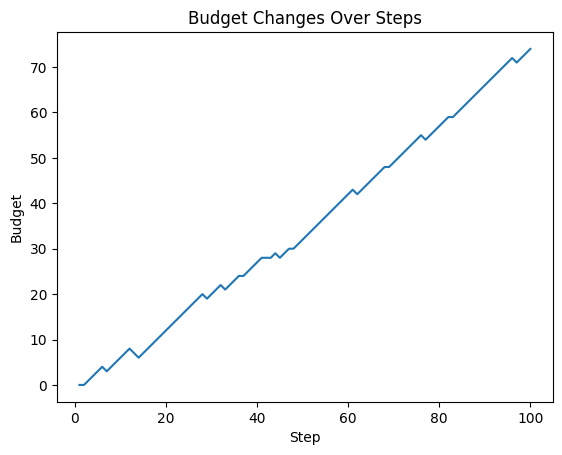

In [48]:
# results
rsp_agent.plot_budget_history()

### RSP agent vs Random agent visualization

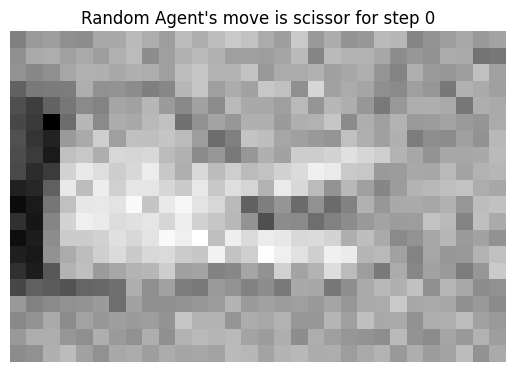

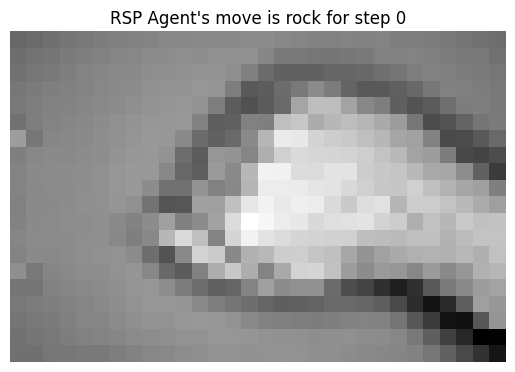

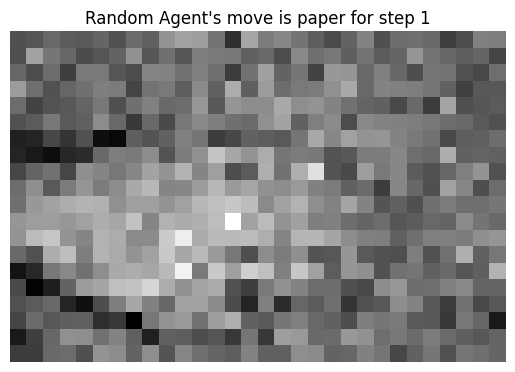

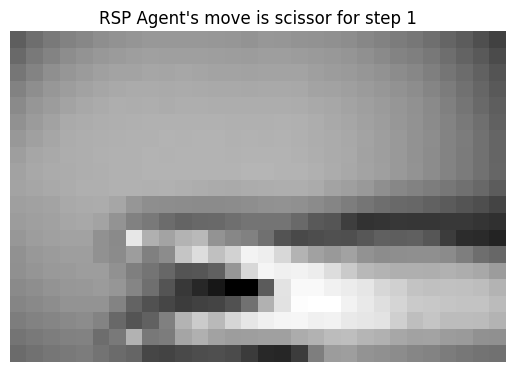

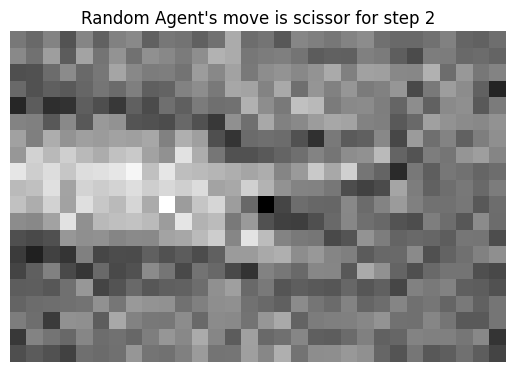

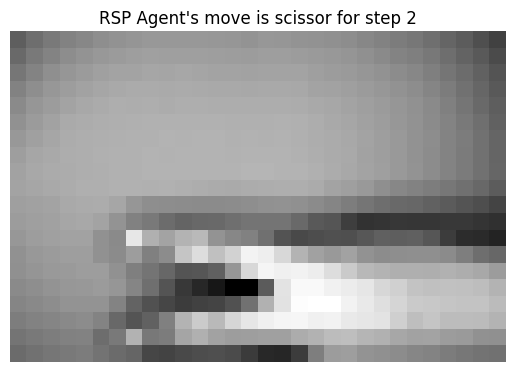

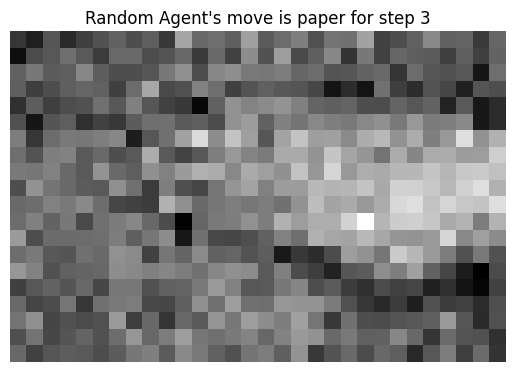

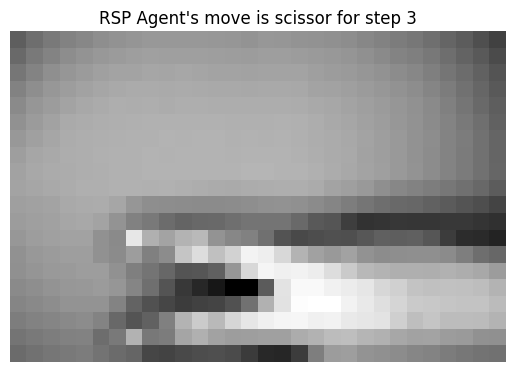

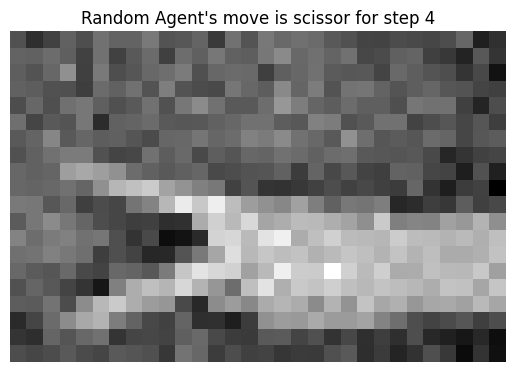

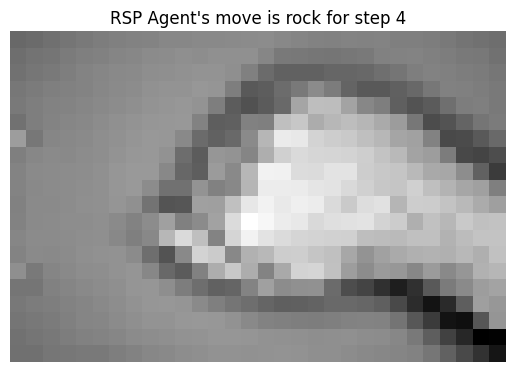

In [32]:
n_turns = 5
play(rsp_agent, random_agent, n_turns, enable_plots=True)

## Evaluation in Test Set
In this section the RSP agent plays against Random agent in whole test set.

In [54]:
def evaluate_agent_in_test_set(rsp_agent, random_agent):
    for idx, i in enumerate(test_images):
      image = random_agent.image_preprocess(test_images[idx])
      rsp_label = rsp_agent.next_step(image)
      rsp_agent.update_budget(rsp_label, test_labels[idx])

In [55]:
# initialize rsp_agent and random_agent with their params
initial_budget = 0
rsp_agent = RSPAgent(cnn_model, test_images, test_labels, budget=initial_budget , cnn_image_need = True, flattened_image_need = False)
random_agent = RandomAgent(test_images, test_labels)

# set the number of turns for the game
evaluate_agent_in_test_set(rsp_agent, random_agent)
print(f"The starting budget was {initial_budget} euros. After {len(test_labels)} turns of the game, the current budget is {rsp_agent.budget} euros.")

The starting budget was 0 euros. After 438 turns of the game, the current budget is 348 euros.


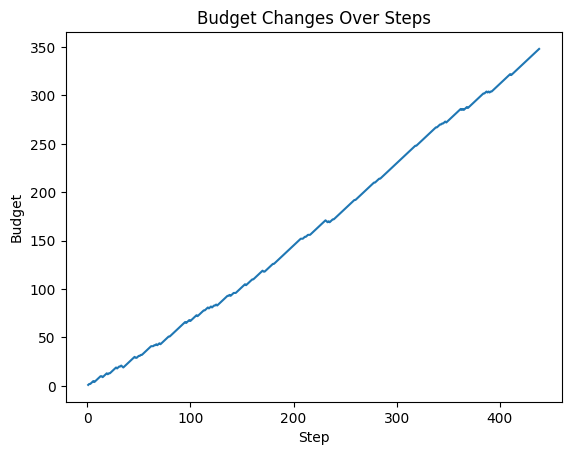

In [56]:
# results
rsp_agent.plot_budget_history()

### Try an image outside of the dataset.

In [71]:
test_image = io.imread("/content/test_image.png")
reshaped_img = test_image[:, :, :3]
test_image = color.rgb2gray(reshaped_img)
np.array(test_image)
test_list = []
test_list.append(np.array(test_image))

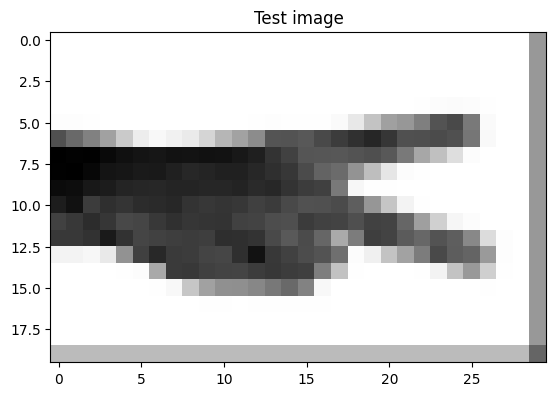

In [74]:
resized_test_image = resize_images(test_list)
plt.imshow(resized_test_image[0], cmap='gray')
plt.title('Test image')
plt.show()

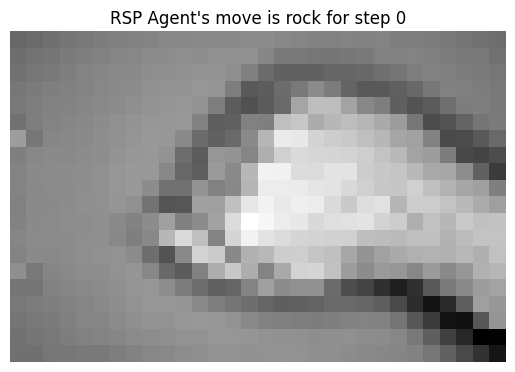

In [81]:
rsp_label = rsp_agent.next_step(resized_test_image[0])
rsp_agent.plot_image(rsp_label, 0)

The RSP agent sucessfully recognized the external test image as "Scissor" move and it answered appropriately with a "Rock" move.